In [17]:
CHECKPOINT_PATH='/local/home/ekoller/sam_data/sam_vit_b_01ec64.pth'


import torch
import os 
import glob
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
from collections import Counter
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_b"

cuda_available = torch.cuda.is_available()
print(f"CUDA available: {cuda_available}")
DEVICE = torch.device('cuda:0' if cuda_available else 'cpu')
print(f"Using device: {DEVICE}")


data_dir ='/local/home/ekoller/R3Scan'
scenes_dir = '/local/home/ekoller/R3Scan/scenes'
scan_id= "38770c95-86d7-27b8-8717-3485b411ddc7" #is reference scan  since it is a reference scan everything shouls be correctly hit
curr_scan_id = "38770c9d-86d7-27b8-869e-4f713b04f290" 
new_scan_id =  "38770c95-86d7-27b8-8717-3485b411ddc7"
frame_number = "000015"
patch_height = 9
patch_width = 16




CUDA available: True
Using device: cuda:0


This codesegment will do the following: for the projection of the current scene do the bounding boxes IMPORTANT: LOOK IN THE RAY INTERSECTION FILE FIRST THAT THE PROJECTION EXISTS!!



In [10]:
# load the sam tools
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


mask_generator = SamAutomaticMaskGenerator(sam)


#generate the mask for the image
# Give the path of your imag

IMAGE_PATH= osp.join(data_dir, "proj", curr_scan_id, "color", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
print("image path", IMAGE_PATH)
# Read the image from the path
image= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


# Generate segmentation mask
try:
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Generate segmentation mask
    output_mask = mask_generator.generate(image_rgb)
    print(output_mask)

except RuntimeError as e:
    if 'out of memory' in str(e):
        print('CUDA out of memory. Consider reducing batch size or model complexity.')
        torch.cuda.empty_cache()
    else:
        raise e
    



image path /local/home/ekoller/R3Scan/proj/38770c9d-86d7-27b8-869e-4f713b04f290/color/proj_pose_38770c95-86d7-27b8-8717-3485b411ddc7_000015.jpg
[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 102743, 'bbox': [658, 0, 301, 450], 'predicted_iou': 1.0316576957702637, 'point_coords': [[705.0, 42.1875]], 'stability_score': 0.9802192449569702, 'crop_box': [0, 0, 960, 540]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, 

In [11]:
# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None):
     if axes:
        ax = axes
     else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
     sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
     # Plot for each segment area
     for val in sorted_result:
        mask = val['segmentation']
        img = np.ones((mask.shape[0], mask.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, mask*0.5)))

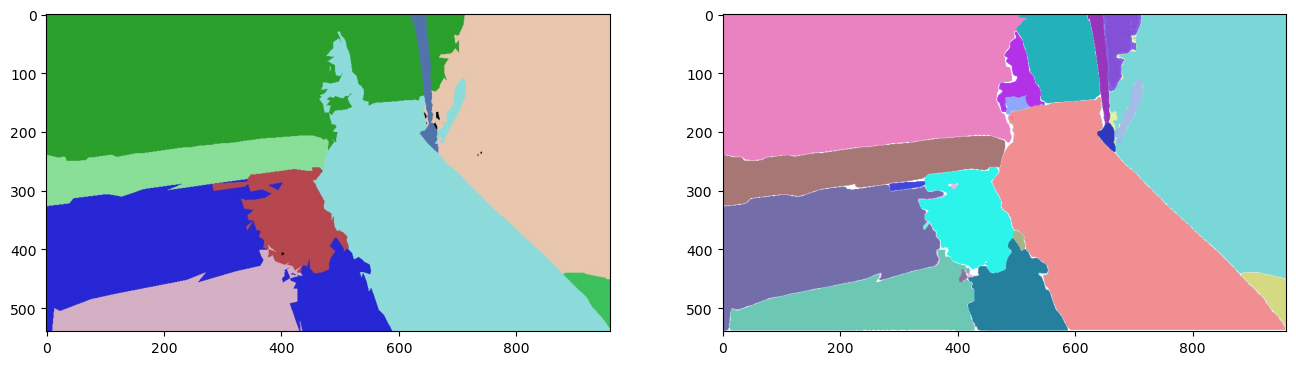

In [12]:
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(output_mask, axes[1])

In [14]:
#this codesegment takes in a semantic segmentation of the projection with sam and translates it into the object ids
def bounding_boxes_for_projection(data_dir, curr_scan_id, new_scan_id, frame_number):
    #access the projection

    proj_rgb= osp.join(data_dir, "proj", curr_scan_id, "obj_id", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    obj_mat = cv2.imread(proj_rgb, cv2.IMREAD_UNCHANGED)
    img_height, img_width= obj_mat.shape
    new_id = np.zeros_like(obj_mat)
    
    for h in range(0, img_height, patch_height):
        for w in range(0, img_width, patch_width):
            patch = obj_mat[h:h+patch_height, w:w+patch_width]
             # flatten the array to 1d
            flattened_patch = patch.flatten()
             # Find the most common value
            value_counts = Counter(flattened_patch)
            most_common_value = value_counts.most_common(1)[0][0]
            # Fill the patch with the most common color
            new_id[h:h+patch_height, w:w+patch_width] = most_common_value

    #compute the boundingboxes based on that new obj_id_mask
    bounding_boxes = []
    unique_ids = np.unique(new_id)

    for obj_id in unique_ids:
        # Create mask for current object ID
        mask = (new_id == obj_id)

        # Find bounding box coordinates
        rows, cols = np.nonzero(mask)
        if len(rows) > 0 and len(cols) > 0:
            min_row, max_row = np.min(rows) - (patch_height), np.max(rows) + (patch_height)
            min_col, max_col = np.min(cols) - (patch_width), np.max(cols) + (patch_width)

            # Calculate height and width
            height = max_row - min_row + 1
            width = max_col - min_col +1

            # Store bounding box information
            bounding_boxes.append({
                'object_id': obj_id,
                'bbox': [min_col, min_row, width, height]
            })

    



    #this part is only to sanity check how the values look like but for efficiecy reasons we compute the boxes based on only the object id
    proj_rgb= osp.join(data_dir, "proj", curr_scan_id, "color", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    rgb_img = cv2.imread(proj_rgb, cv2.IMREAD_UNCHANGED)
    img_height, img_width, _ = rgb_img.shape
    new_image = np.zeros_like(rgb_img)
    
    for h in range(0, img_height, patch_height):
        for w in range(0, img_width, patch_width):
            patch = rgb_img[h:h+patch_height, w:w+patch_width]
             # Reshape patch to a 2D array of shape (num_pixels, 3)
            reshaped_patch = patch.reshape(-1, patch.shape[2])
            
            # Find the most common color
            color_counts = Counter(map(tuple, reshaped_patch))
            most_common_color = color_counts.most_common(1)[0][0]
            # Fill the patch with the most common color
            new_image[h:h+patch_height, w:w+patch_width] = most_common_color

    cv2.imshow('Image patchwise', new_image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return bounding_boxes
                       

bounding_boxes_for_projection(data_dir, curr_scan_id, new_scan_id, frame_number)
 



    #     #compute segmentation mask using sam 
    # sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)

    # mask_generator = SamAutomaticMaskGenerator(sam)
    # #access the projection
    # proj_rgb= osp.join(data_dir, "proj", curr_scan_id, "color", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    # rgb_img = cv2.imread(proj_rgb, cv2.IMREAD_UNCHANGED)


    # # Clear GPU cache
    # torch.cuda.empty_cache()

    # # Generate segmentation mask
    # output_mask = mask_generator.generate(rgb_img)
    # print(output_mask)


    # #access the projection ids
    # proj= osp.join(data_dir, "proj", curr_scan_id, "obj_id", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
    # obj_ids = cv2.imread(proj, cv2.IMREAD_UNCHANGED)
    
    # #create a intermediate mask which for each segmentation part from the sam stuff does the following
    # # fill in all the entries of a segment part with the id which is mostly found in that segment
    
    # obj_id_mask = np.zeros_like(obj_ids)

    # #go over the segments
    # for value in output_mask:
    #     segmentation = value["segmentation"]
    #     #use the mask
    #     masked_elements = obj_ids[segmentation]

    #     if masked_elements.size > 0:  # Check if there are any True values in the mask
    #         most_common_value = Counter(masked_elements).most_common(1)[0][0]

    #         #write those values into the new obj id mask
    #         obj_id_mask[segmentation] = most_common_value


    # #np.set_printoptions(threshold=np.inf, linewidth=np.inf)
    # print("obj_id_mask", obj_id_mask)
    # """
    # save the newly generated mask: to do
    # """


    # #compute the boundingboxes based on that new obj_id_mask
    # bounding_boxes = []
    # unique_ids = np.unique(obj_id_mask)

    # for obj_id in unique_ids:
    #     # Create mask for current object ID
    #     mask = (obj_id_mask == obj_id)

    #     # Find bounding box coordinates
    #     rows, cols = np.nonzero(mask)
    #     if len(rows) > 0 and len(cols) > 0:
    #         min_row, max_row = np.min(rows), np.max(rows)
    #         min_col, max_col = np.min(cols), np.max(cols)

    #         # Calculate height and width
    #         height = max_row - min_row + 1
    #         width = max_col - min_col + 1

    #         # Store bounding box information
    #         bounding_boxes.append({
    #             'object_id': obj_id,
    #             'bbox': [min_col, min_row, width, height]
    #         })


    # return bounding_boxes
    # unique_values = np.unique(obj_id_mask)

    # # Count the number of unique values
    # num_unique_values = len(unique_values)
    # #np.set_printoptions(threshold=np.inf, linewidth=np.inf)
   
    # print("unique values", num_unique_values, unique_values)

    


In [15]:
#display the newly computed bounding boxes 
bboxes = bounding_boxes_for_projection(data_dir, curr_scan_id, new_scan_id, frame_number)
print(" bounding boxes ",bboxes)
#access the projection
proj_rgb= osp.join(data_dir, "proj", curr_scan_id, "color", "proj_pose_"+ str(new_scan_id)+"_"+str(frame_number)+".jpg")
rgb_img = cv2.imread(proj_rgb, cv2.IMREAD_COLOR)

# Draw bounding boxes and object IDs
for box in bboxes:
        min_col, min_row, width, height = box['bbox']
        min_col, min_row, width, height = int(min_col), int(min_row), int(width), int(height)

        cv2.rectangle(rgb_img, (min_col, min_row), (min_col + width, min_row + height), (0, 255, 0), 2)
        cv2.putText(rgb_img, str(box['object_id']), (min_col, min_row - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Display the image
cv2.imshow('Image with Bounding Boxes', rgb_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 103350, 'bbox': [459, 142, 498, 396], 'predicted_iou': 1.0203075408935547, 'point_coords': [[945.0, 531.5625]], 'stability_score': 0.9843608736991882, 'crop_box': [0, 0, 960, 540]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 16079, 'bbox': [417, 382, 170, 156], 'predicted_iou': 1.01838433742

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to target thread (0x55970ecaf2b0)

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to target thread (0x55970ecaf2b0)

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to target thread (0x55970ecaf2b0)

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to target thread (0x55970ecaf2b0)

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to target thread (0x55970ecaf2b0)

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to target thread (0x55970ecaf2b0)

QObject::moveToThread: Current thread (0x55970ecaf2b0) is not the object's thread (0x55978dedc080).
Cannot move to tar

this segment does the reading in to the sam framework
to do: save also the  image that we get
find out what we need exactly, this is for the input images!!


In [ ]:

def generate_sam_data(path_to_img):

    sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


    mask_generator = SamAutomaticMaskGenerator(sam)

    # Give the path of your image
    IMAGE_PATH= osp.join(path_to_img)
    # Read the image from the path
    image= cv2.imread(IMAGE_PATH)
    # Convert to RGB format
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Generate segmentation mask
    try:
        # Clear GPU cache
        torch.cuda.empty_cache()

        # Generate segmentation mask
        output_mask = mask_generator.generate(image_rgb)
        print(output_mask)

    except RuntimeError as e:
        if 'out of memory' in str(e):
            print('CUDA out of memory. Consider reducing batch size or model complexity.')
            torch.cuda.empty_cache()
        else:
            raise e
        
    return output_mask

In [ ]:
#returns for every semantic regtion of thet frame x_min,x_max, y_min, y_max, height, width
def get_sam_boundingboxes_frame(path_to_img):

    data_dict = generate_sam_data(path_to_img)
    print("sam ressult", data_dict)

    bboxes = []
     #iterate through evey segmentation field to get the result
    for val in data_dict:
        bbox = val['bbox']
        x_min, y_min, width, height = bbox
        x_max = x_min + width
        y_max = y_min + height
        bboxes.append(np.array([x_min,x_max, y_min, y_max, height, width]))


    return bboxes

In [ ]:
#wil be called by the rescan input image
def get_all_sam_semantic_boxes_scene(data_dir, scan_id):

    #go to the folder of the scene
    folder_path = osp.join(data_dir, "scenes", scan_id, "sequence")
    print("folderpath", folder_path)
    file_pattern = 'frame-*.color.jpg'


    #search for all the colour files
    file_list = glob.glob(os.path.join(folder_path, file_pattern))
    print("file list", file_list)

    #create a directory in which the boxes get saved
    output_path = osp.join(data_dir, "sam_data", scan_id, "bboxes")
    try:
        os.makedirs(output_path, exist_ok=True)
    except Exception as e:
        print(f"Failed to create directory {output_path}: {e}")

    for file in file_list:
        frame_boxes = get_sam_boundingboxes_frame(file)

        #get the name of the file currently accessed
        filename = os.path.basename(file)
        pattern_part = filename.split('.')[0]

        filename = pattern_part + ".npy"
        #make a new file to save the information of the boundingboxes
        box_file_path = osp.join(output_path, filename)
        success_obj = np.save(box_file_path, frame_boxes)
        print("success obj", success_obj)

In [ ]:
get_all_sam_semantic_boxes_scene(data_dir,scan_id)

below is unused lol

In [ ]:
# Function that inputs the output and plots image and mask
def show_output(result_dict,axes=None):
      if axes:
         ax = axes
      else:
         ax = plt.gca()
         ax.set_autoscale_on(False)
      sorted_result = sorted(result_dict, key=(lambda x: x['area']),      reverse=True)
      # Plot for each segment area
      for val in sorted_result:
         mask = val['segmentation']
         img = np.ones((mask.shape[0], mask.shape[1], 3))
         color_mask = np.random.random((1, 3)).tolist()[0]
         for i in range(3):
               img[:,:,i] = color_mask[i]
               ax.imshow(np.dstack((img, mask*0.5)))
         
         
         # Display bounding box
         bbox = val['bbox']
         x_min, y_min, width, height = bbox
         x_max = x_min + width
         y_max = y_min + height
         rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
         ax.add_patch(rect)
         ax.add_patch(rect)

      # bboxes = get_sam_boundingboxes(data_dir, scan_id, frame_number)
      # for box in bboxes:
      #    x_min,x_max, y_min, y_max, width, height = box
      #    rect = plt.Rectangle((x_min, y_min), width, height, fill=False, edgecolor='red', linewidth=2)
      #    ax.add_patch(rect)
      #    ax.add_patch(rect)
          
      

[{'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 92828, 'bbox': [0, 0, 467, 247], 'predicted_iou': 0.9876569509506226, 'point_coords': [[165.0, 126.5625]], 'stability_score': 0.978972852230072, 'crop_box': [0, 0, 960, 540]}, {'segmentation': array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]), 'area': 1797, 'bbox': [57, 495, 44, 44], 'predicted_iou': 0.9872605800628662, 'po

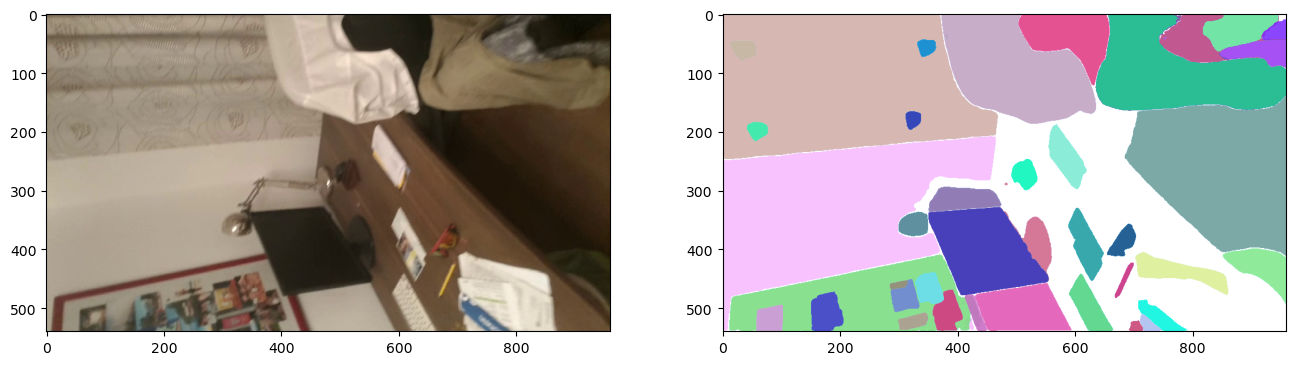

In [21]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)


mask_generator = SamAutomaticMaskGenerator(sam)

# Give the path of your image
IMAGE_PATH= osp.join(data_dir,"scenes",new_scan_id,"sequence","frame-"+str(frame_number)+".color.jpg")


# Read the image from the path
image= cv2.imread(IMAGE_PATH)
# Convert to RGB format
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate segmentation mask
try:
    # Clear GPU cache
    torch.cuda.empty_cache()

    # Generate segmentation mask
    output_mask = mask_generator.generate(image_rgb)
    print(output_mask)

except RuntimeError as e:
    if 'out of memory' in str(e):
        print('CUDA out of memory. Consider reducing batch size or model complexity.')
        torch.cuda.empty_cache()
    else:
        raise e
_,axes = plt.subplots(1,2, figsize=(16,16))
axes[0].imshow(image_rgb)
show_output(output_mask, axes[1])